In [1]:
import os
from PIL import Image
import pandas as pd


In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

# Load the CSV containing image paths
csv_path = "train_image_paths.csv"
df = pd.read_csv(csv_path, header=None, names=['image_path'])

# Extract class from the path
def extract_class(path):
    parts = path.split('/')
    body_part = parts[2]
    study_type = parts[4]
    label = study_type.split('_')[1]
    return f"{body_part} {label}"

df['class_name'] = df['image_path'].apply(extract_class)

# Show the DataFrame
# import ace_tools as tools; tools.display_dataframe_to_user(name="Labeled Image Paths", dataframe=df)

df.head()


,image_path,class_name
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER positive
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER positive
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER positive
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER positive
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER positive


In [10]:
# Save the DataFrame with class names to a new CSV file
new_csv_path = "train_image_labeled.csv"
df.to_csv(new_csv_path, index=False)

new_csv_path


'train_image_labeled.csv'

In [11]:
# Save the DataFrame with class names to a new CSV file
df.to_csv(new_csv_path, index=False)



In [16]:
csv_path = r"train_image_labeled.csv"
df = pd.read_csv(csv_path)
df.columns


Index(['image_path', 'class_name'], dtype='object')

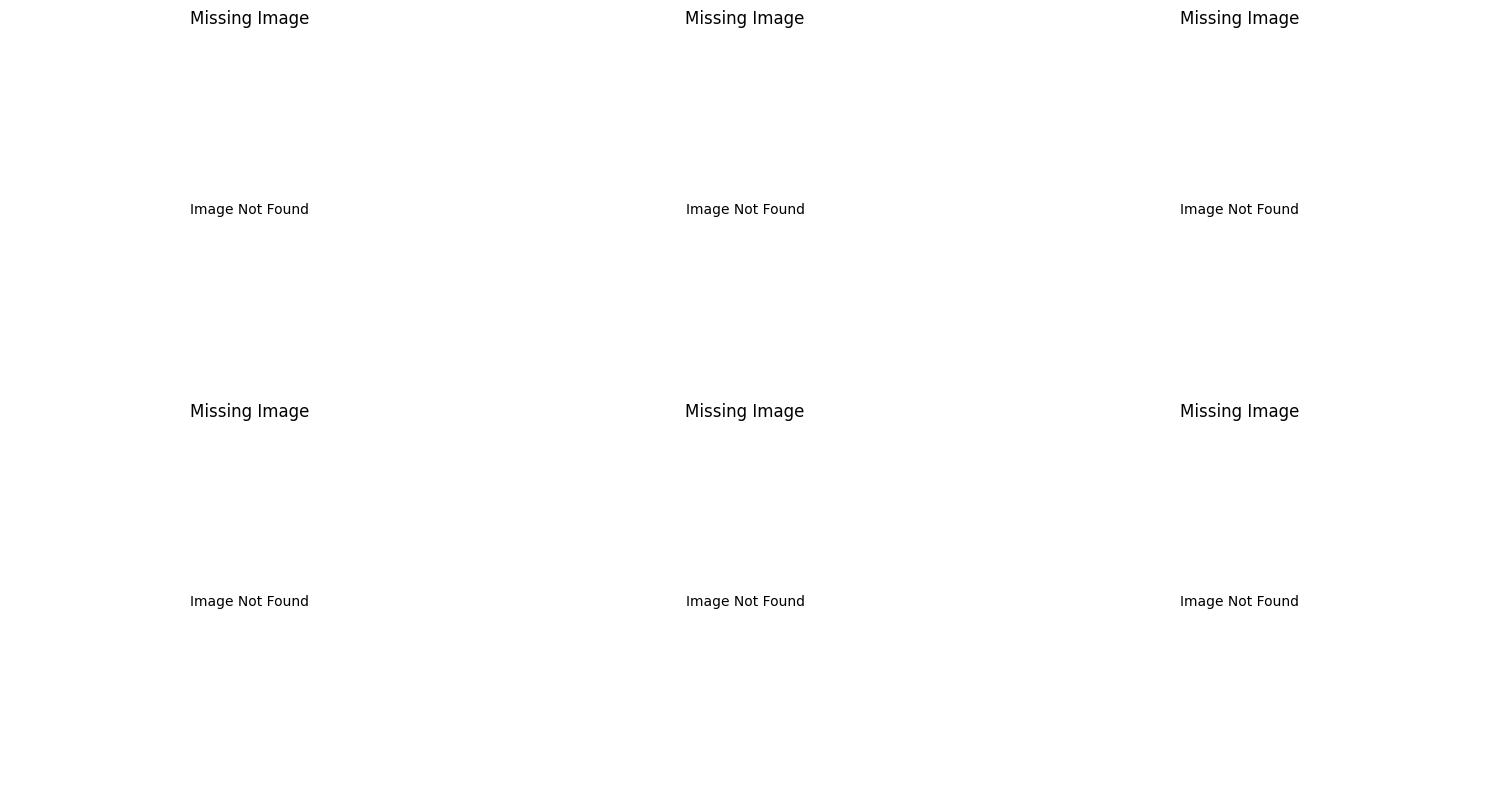

In [17]:
import random

# Select random samples from the dataframe
sampled_df = df.sample(n=6).reset_index(drop=True)

# Plot random images with class names
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, row in sampled_df.iterrows():
    image_path = row['image_path']
    class_label = row['class_name']
    
    # Check if file exists before loading
    if os.path.exists(image_path):
        image = Image.open(image_path).convert('L')  # Convert to grayscale for X-rays
        axes[idx].imshow(image, cmap='gray')
        axes[idx].set_title(class_label)
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, 'Image Not Found', ha='center', va='center')
        axes[idx].set_title("Missing Image")
        axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [24]:
BASE_DIR = "D:\\Downloads\\MURA-v1.1\\MURA-v1.1"  # Adjust if nested
df = pd.read_csv(os.path.join(BASE_DIR, "train_image_labeled.csv"))
df

,image_path,class_name
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER positive
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER positive
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER positive
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER positive
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER positive
...,...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,XR_HAND negative
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,XR_HAND negative
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,XR_HAND negative
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,XR_HAND negative


CNN

Epoch [1/10], Loss: 2.3461, Accuracy: 19.66%
Epoch [2/10], Loss: 1.7915, Accuracy: 35.20%
Epoch [3/10], Loss: 1.5219, Accuracy: 42.88%
Epoch [4/10], Loss: 1.2496, Accuracy: 53.09%
Epoch [5/10], Loss: 0.9097, Accuracy: 66.09%
Epoch [6/10], Loss: 0.6529, Accuracy: 76.00%
Epoch [7/10], Loss: 0.4766, Accuracy: 82.71%
Epoch [8/10], Loss: 0.3591, Accuracy: 87.20%
Epoch [9/10], Loss: 0.2776, Accuracy: 90.77%
Epoch [10/10], Loss: 0.2215, Accuracy: 92.50%
                      precision    recall  f1-score   support

   XR_ELBOW negative       0.44      0.35      0.39       116
   XR_ELBOW positive       0.37      0.39      0.38        87
  XR_FINGER negative       0.48      0.45      0.46       115
  XR_FINGER positive       0.42      0.63      0.50       109
 XR_FOREARM negative       0.24      0.21      0.22        86
 XR_FOREARM positive       0.35      0.38      0.36        92
    XR_HAND negative       0.50      0.48      0.49       106
    XR_HAND positive       0.49      0.47      0.48 

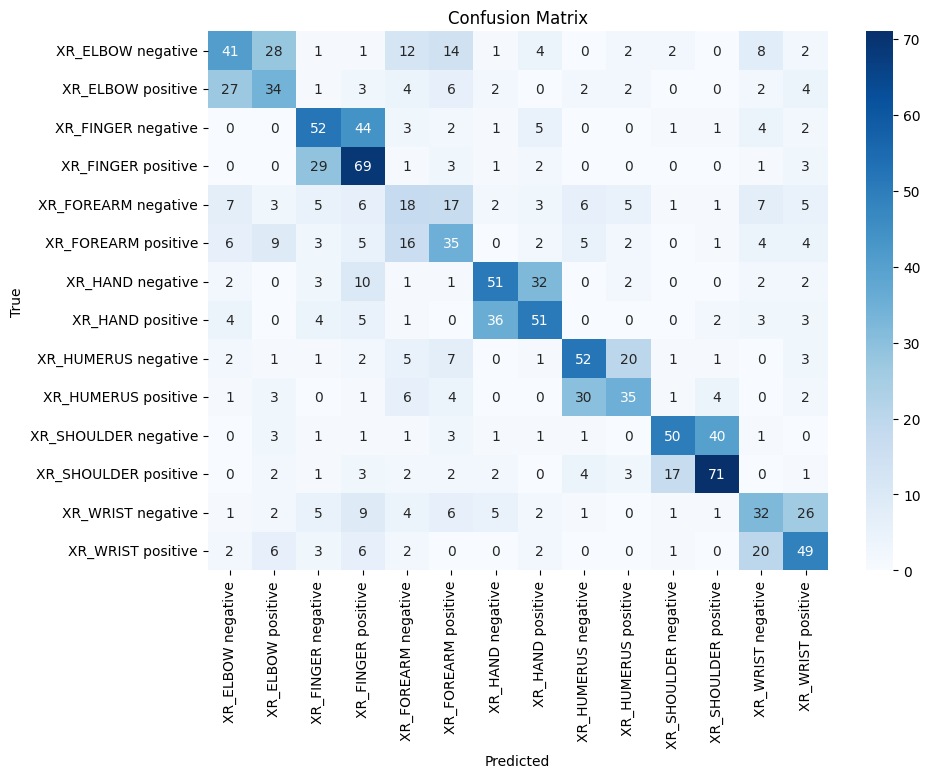

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import pandas as pd

BASE_DIR = "D:\\Downloads\\MURA-v1.1\\MURA-v1.1"  # Adjust if nested
df = pd.read_csv(os.path.join(BASE_DIR, "train_image_labeled.csv"))
df

# Select 500 images per class
df = df.groupby('class_name').sample(n=500, random_state=42).reset_index(drop=True)

def preprocess_image(image_path, target_size=(224, 224)):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    image = transforms.ToTensor()(image)
    return image

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, df, transform=None, base_dir=BASE_DIR):
        self.df = df
        self.transform = transform
        self.base_dir = base_dir
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        relative_path = self.df.iloc[idx, 0]
        image_path = os.path.join(self.base_dir, relative_path.lstrip("MURA-v1.1/"))
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = preprocess_image(image_path)
        label = self.df.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

# Label Encoding
label_map = {label: idx for idx, label in enumerate(np.unique(df['class_name']))}
df['class_name'] = df['class_name'].map(label_map)

# Split the data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# DataLoader
train_dataset = ImageDataset(train_df, base_dir=BASE_DIR)
val_dataset = ImageDataset(val_df, base_dir=BASE_DIR)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# CNN Model 
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNNModel(num_classes=len(label_map))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

def validate(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

train(model, train_loader, criterion, optimizer, num_epochs=10)
predictions, labels = validate(model, val_loader)

print(classification_report(labels, predictions, target_names=[label for label, idx in label_map.items()]))

conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[label for label in label_map], yticklabels=[label for label in label_map])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Save the model
torch.save(model.state_dict(), os.path.join(BASE_DIR, "cnn_model.pth"))
print(f"Model saved to {os.path.join(BASE_DIR, 'cnn_model.pth')}")


Model saved to D:\Downloads\MURA-v1.1\MURA-v1.1\cnn_model.pth


In [27]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import pandas as pd
import joblib

# Base directory for the dataset
BASE_DIR = "D:\\Downloads\\MURA-v1.1\\MURA-v1.1"  # Adjust if nested
df = pd.read_csv(os.path.join(BASE_DIR, "train_image_labeled.csv"))

# Select 500 images per class
df = df.groupby('class_name').sample(n=500, random_state=42).reset_index(drop=True)

# Preprocessing for MobileNet (ImageNet normalization)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    return image

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, df, base_dir=BASE_DIR):
        self.df = df
        self.base_dir = base_dir
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        relative_path = self.df.iloc[idx, 0]
        image_path = os.path.join(self.base_dir, relative_path.lstrip("MURA-v1.1/"))
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = preprocess_image(image_path)
        label = self.df.iloc[idx, 1]
        return image, label

# Label Encoding
label_map = {label: idx for idx, label in enumerate(np.unique(df['class_name']))}
df['class_name'] = df['class_name'].map(label_map)

# Reverse label map for prediction output
reverse_label_map = {idx: label for label, idx in label_map.items()}

# Split the data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# DataLoader
train_dataset = ImageDataset(train_df, base_dir=BASE_DIR)
val_dataset = ImageDataset(val_df, base_dir=BASE_DIR)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained MobileNetV2 and remove the classifier
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet = nn.Sequential(*list(mobilenet.children())[:-1])  # Remove the last layer
mobilenet.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet.to(device)

# Feature extraction function
def extract_features(loader, model):
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            outputs = model(images)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
    return np.vstack(features), np.concatenate(labels)

# Extract features
print("Extracting features from training set...")
train_features, train_labels = extract_features(train_loader, mobilenet)
print("Extracting features from validation set...")
val_features, val_labels = extract_features(val_loader, mobilenet)

# Train SVM classifier
print("Training SVM classifier...")
svm = SVC(kernel='linear', random_state=42)
svm.fit(train_features, train_labels)

# Save the SVM model
model_save_path = os.path.join(BASE_DIR, "svm_model.joblib")
joblib.dump(svm, model_save_path)
print(f"SVM model saved to {model_save_path}")

# Load the SVM model (for demonstration; in practice, you’d load it in a separate script)
loaded_svm = joblib.load(model_save_path)
print("SVM model loaded successfully")

# Validate the loaded model
val_predictions = loaded_svm.predict(val_features)
print(classification_report(val_labels, val_predictions, target_names=[label for label, idx in label_map.items()]))

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[label for label in label_map], yticklabels=[label for label in label_map])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



c:\Users\085\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\085\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting features from training set...


: 

In [ ]:
# Load the SVM model (for demonstration; in practice, you’d load it in a separate script)
loaded_svm = joblib.load(model_save_path)
print("SVM model loaded successfully")
#Validate the loaded model
val_predictions = loaded_svm.predict(val_features)
print(classification_report(val_labels, val_predictions, target_names=[label for label, idx in label_map.items()]))

# Single image prediction function
def predict_single_image(image_path, mobilenet_model, svm_model, reverse_label_map):
    # Preprocess the image
    image = preprocess_image(image_path)
    image = image.unsqueeze(0)  # Add batch dimension
    
    # Extract features with MobileNet
    mobilenet_model.to(device)
    image = image.to(device)
    with torch.no_grad():
        features = mobilenet_model(image)
        features = features.view(features.size(0), -1).cpu().numpy()
    
    # Predict with SVM
    prediction = svm_model.predict(features)
    predicted_label = reverse_label_map[prediction[0]]
    return predicted_label

# Example usage of single image prediction
example_image_path = "D:\\Downloads\\MURA-v1.1\\MURA-v1.1\\train\\XR_FOREARM\\patient09309\\study1_negative\\image2.png"  # Replace with a valid path
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)
